In [1]:
#Import directories
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as sp
import seaborn as sns

<h2>Outliers</h2>
<p>In this section we will be using different methods to identify outliers.</p>

In [2]:
cars = pd.read_csv("http://staff.city.ac.uk/~sbbk529/Teaching/Resources/INM430/accord_sedan.csv")
cars    

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic
...,...,...,...,...,...,...
412,12456,67564,2006,lx,4 Cyl,Automatic
413,10995,69775,2006,ex,4 Cyl,Automatic
414,16000,77997,2006,exl,4 Cyl,Automatic
415,14700,61892,2006,ex,4 Cyl,Automatic


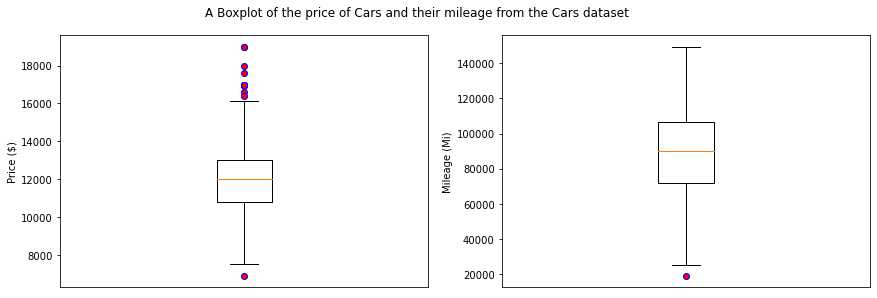

In [3]:
#Creating boxplots of their price and mileage 
#First price
flierprops = dict(marker='o',markerfacecolor='r', markeredgecolor='b')
fig1 = plt.figure() #Create a figure and subplot of 1x2
sp1 = fig1.add_subplot(121)
sp1.boxplot(cars.price, flierprops=flierprops)
sp1.set_ylabel("Price ($)")
plt.xticks([0]," ") #Remove x axis labels i.e. set first index to empty string

#Next Mileage
sp1 = fig1.add_subplot(122)
sp1.set_ylabel("Mileage (Mi)")
sp1.boxplot(cars.mileage, flierprops=flierprops)
plt.xticks([0]," ")
#Adjust spacing
fig1.subplots_adjust(right = 2, top = 1) 
plt.suptitle("A Boxplot of the price of Cars and their mileage from the Cars dataset", x=0.95, y= 1.1) #Adjust top title.
plt.show()

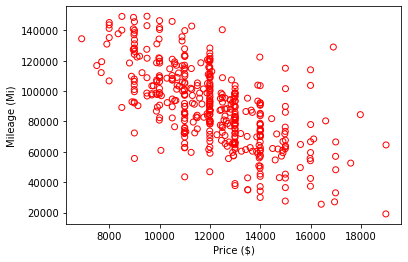

In [4]:
#Creating a combined plot of both price and mileage
plt.scatter(cars.price, cars.mileage, marker='o',facecolors = 'none', edgecolors='r')
plt.xlabel("Price ($)")
plt.ylabel("Mileage (Mi)")
plt.show()

<p>We will be identifying outliers. For this section, I have first created a function to calculate the upper and lower limits of the price and mileage columns. The method used to calculate these bounds is summing/subtracting two times the standard deviation from the mean. I have assumed any values that lie outside these two bounds are considered outliers. I have created a couple new columns to store the result of whether the values are outliers or not.</p>

In [5]:
car_outl = cars.copy()
def find_limits_mean(col):
    """
    Takes a series and returns mean, std and upper and lower limits for a column.
    """
    mu = np.mean(col)
    sigma = np.std(col)
    upper_limit = mu + 2*sigma
    lower_limit = mu - 2*sigma
    return upper_limit, lower_limit

#The columns to check outliers for
columns = ["price","mileage"]

for col in columns:
    ul, ll = find_limits_mean(car_outl[col])
    newcol = "isOutlier" + col.capitalize()
    car_outl[newcol] = [1 if (val > ul or val < ll) else 0 for val in car_outl[col]]
    

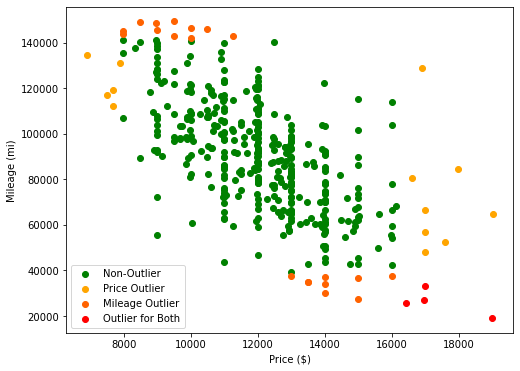

In [6]:
#Separating them into what is an outlier.
car_no = car_outl.loc[((car_outl.isOutlierPrice != 1) & (car_outl.isOutlierMileage != 1))]
car_onlyP = car_outl.loc[((car_outl.isOutlierPrice == 1) & (car_outl.isOutlierMileage != 1))]
car_onlyM = car_outl.loc[((car_outl.isOutlierPrice != 1) & (car_outl.isOutlierMileage == 1))]
car_all = car_outl.loc[((car_outl.isOutlierPrice == 1) & (car_outl.isOutlierMileage == 1))]

data = [car_no, car_onlyP, car_onlyM,car_all]
color = ["green","orange","#ff6200","red"]
legend = ["Non-Outlier", "Price Outlier","Mileage Outlier","Outlier for Both"]

fig2 = plt.figure(figsize=(8,6))
for df,c in zip(data,color):
    plt.scatter(x=df.price,y=df.mileage, color=c)
plt.legend(legend)
plt.ylabel("Mileage (mi)")
plt.xlabel("Price ($)")
plt.show()

<p>Above, I have plotted the data in a scatter plot, splitting outliers based on the two variables- whether it is an outlier for one variable or both as shown in the legend. I do not believe the values can be truly considered outliers, some points seem like they fit quite well with the fit. Some of the "non-outlier" values seem like they could be outliers, for example the car priced at $9000 and has done 55000 miles.</p>

<h3>Mahalanobis distance to identify outliers</h3>

In [7]:
def mahalanobis(x, cov=None):
    """Method to calculte mahalanobis distance to detect outliers."""
    x_mu = x - np.mean(x)
    if not cov:
        cov = np.cov(x.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

data_f = cars.copy()

data_f['mahalanobis'] = mahalanobis(x=data_f[['price', 'mileage']])
data_f.sort_values("mahalanobis",ascending=False)

,price,mileage,year,trim,engine,transmission,mahalanobis
313,16900,129000,2006,ex,6 Cyl,Automatic,21.769291
379,18995,64570,2006,ex,6 Cyl,Automatic,13.904732
259,17975,84504,2006,ex,6 Cyl,Automatic,13.095316
99,15995,114000,2006,lx,6 Cyl,Automatic,11.955053
270,18988,19160,2006,ex,4 Cyl,Automatic,11.690912
...,...,...,...,...,...,...,...
177,11995,92477,2006,ex,6 Cyl,Automatic,0.012448
404,11990,91595,2006,ex,6 Cyl,Automatic,0.005190
66,11988,91420,2006,ex,6 Cyl,Automatic,0.004286
329,11980,89876,2006,ex,4 Cyl,Automatic,0.003877


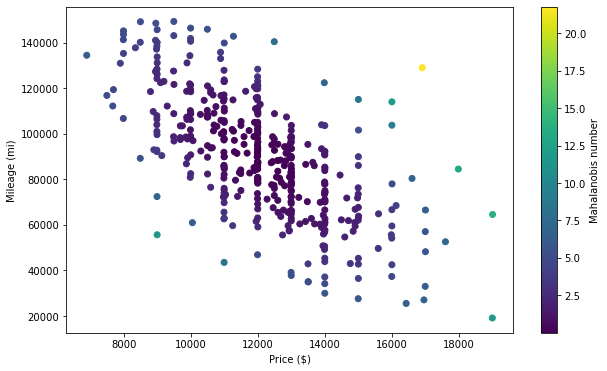

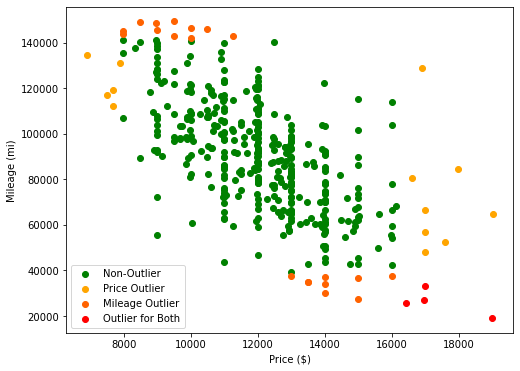

In [8]:
fig3 = plt.figure(figsize=(10,6))
plt.scatter(data_f.price,data_f.mileage,c=data_f.mahalanobis,cmap="viridis")
plt.xlabel("Price ($)")
plt.ylabel("Mileage (mi)")
cbar = plt.colorbar()
cbar.set_label("Mahalanobis number")
plt.show()
fig2

<p>With comparison to the Mahalanobis distance, it is clear that the outliers have been identified as a function of the distance from the other points. This is because the furthest points, i.e. the car at ($16900,129000 miles) has a high mahalanobis distance indicating that it is an outlier. The same coordinate in the mean outlier method, is only an outlier for the Price variable not Mileage. Furthermore, values away from the bulk/ centre of the plot where most of the data is found have higher mahalanobis distance.<br/>This makes it seem that the mahalanobis distance is a better measure for multivariate data.</p>

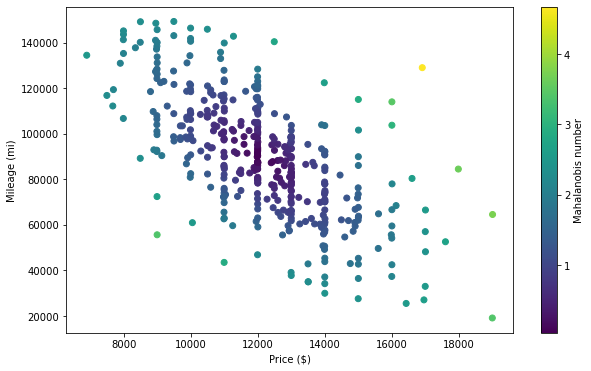

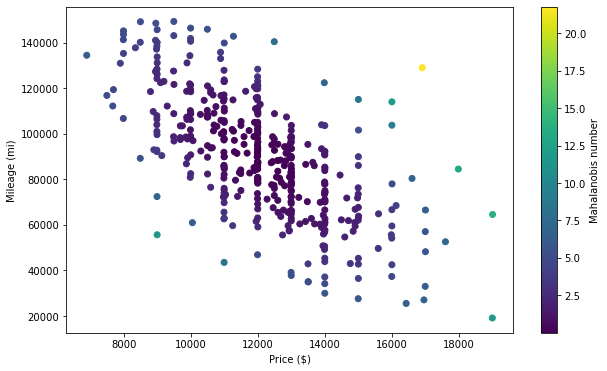

In [9]:
#Trying Mahalanobis using scipy
data_cd = cars.copy()

reshaped_pr_mi = np.array(data_cd[["price","mileage"]])
reshaped_mean = np.array(np.mean(data_cd[["price","mileage"]])).reshape(1,2)
mbd = sp.cdist(reshaped_mean,reshaped_pr_mi,metric="mahalanobis") #mahalanobis distance

fig4 = plt.figure(figsize=(10,6))
plt.scatter(data_f.price,data_f.mileage,c=mbd,cmap="viridis")
plt.xlabel("Price ($)")
plt.ylabel("Mileage (mi)")
cbar = plt.colorbar()
cbar.set_label("Mahalanobis number")
plt.show()
fig3

<h1>Q-Q Plots</h1>
<p>In this section, we will be taking a look at qqplots to visually compare distributions.</p>

In [10]:
#Getting the data.
TB_data = pd.read_csv("http://staff.city.ac.uk/~sbbk529/Teaching/Resources/INM430/TB_burden_countries_2014-09-29.csv")
TB_knn = TB_data.copy()

#Filling in missing data using k-nearest neighbor
#Use KNN Imputation 
from sklearn.impute import KNNImputer
from pandas.api.types import is_numeric_dtype

imputer = KNNImputer(n_neighbors=15)

for col in TB_knn:
    if(is_numeric_dtype(TB_knn[col])):
        TB_knn[col] =  imputer.fit_transform(TB_knn[col].values.reshape(-1,1))
            

In [11]:
#list of the columns and what they mean.
defin = pd.read_csv("https://extranet.who.int/tme/generateCSV.asp?ds=dictionary")
defin.merge(pd.DataFrame(TB_data.columns,columns=["col"]),left_on="variable_name",right_on="col")

,variable_name,dataset,code_list,definition,col
0,country,Country identification,NaN,Country or territory name,country
1,iso_numeric,Country identification,NaN,ISO numeric country/territory code,iso_numeric
2,iso2,Country identification,NaN,ISO 2-character country/territory code,iso2
3,iso3,Country identification,NaN,ISO 3-character country/territory code,iso3
4,c_cdr,Estimates,NaN,Case detection rate (all forms) [also known as...,c_cdr
5,c_cdr_hi,Estimates,NaN,Case detection rate (all forms) [also known as...,c_cdr_hi
6,c_cdr_lo,Estimates,NaN,Case detection rate (all forms) [also known as...,c_cdr_lo
7,e_inc_100k,Estimates,NaN,Estimated incidence (all forms) per 100 000 po...,e_inc_100k
8,e_inc_100k_hi,Estimates,NaN,Estimated incidence (all forms) per 100 000 po...,e_inc_100k_hi
9,e_inc_100k_lo,Estimates,NaN,Estimated incidence (all forms) per 100 000 po...,e_inc_100k_lo


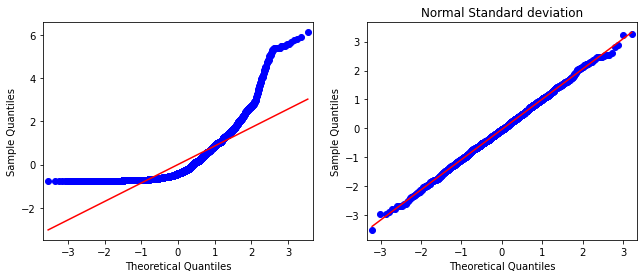

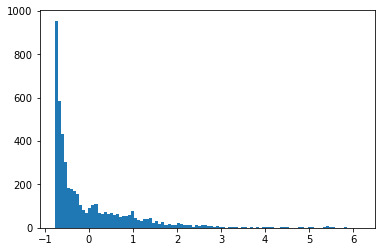

In [79]:
#Standardising the data and finding a Z Score 
#Standardising it reduces the effect of scale and makes trends easier to spot.
mu = TB_knn.e_prev_100k.mean()
sigma = TB_knn.e_prev_100k.std()
z = (TB_knn.e_prev_100k - mu)/sigma

#Plotting a standard deviation and comparing it to the QQ plot 
sd = np.random.normal(0,1,1500)

#Subplot
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.subplots_adjust(right=1.5)

sm.qqplot(z,line="r", ax=axes[0])
plt.title("Prevalence of TB per 100k")

sm.qqplot(sd,line="r", ax=axes[1])
plt.title("Normal Standard deviation")
plt.show()

plt.hist(z,bins=100)
plt.show()


<p>From plotting Quantile-Quantile plot of the data column e_prev_100k - "prevalence of TB per 100,000 individuals", we can see the data is positively skewed. This is shown when compared to the standard deviation. When plotting a histogram of this column, we can also see the same result with a positive skew.</p>

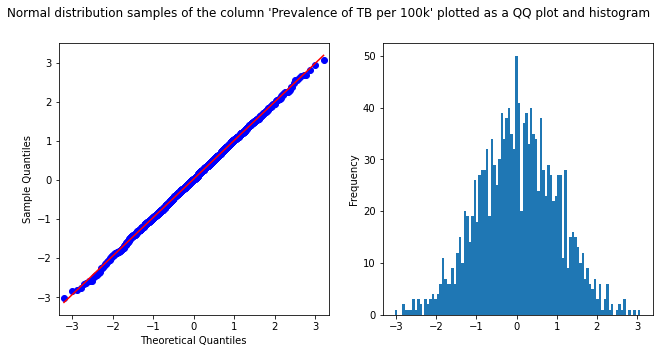

In [73]:
import scipy.stats as stats

#Subplot
fig, axes = plt.subplots(nrows=1,ncols=2)
#change size
fig.set_size_inches(6,5)
#Take samples of data assuming it follows normal distribution.
TB_norm = np.random.normal(z.mean(),z.std(),1500)

nm = sm.qqplot(TB_norm,line="r", ax=axes[0])

plt.hist(TB_norm, bins=100)
plt.ylabel("Frequency")
plt.suptitle("Normal distribution samples of the column 'Prevalence of TB per 100k' plotted as a QQ plot and histogram", x=0.75)
fig.subplots_adjust(right = 1.5)
plt.show()

<p>When sampling the data from the TB dataset for the same e_prev_100k column, we can see that the sampling method turns the data more like a normal distribution. This is shown by the bell-curve shape in the histogram and the regression line of fit perfectly matching with the datapoints.</p>

<h1>Distributions and Sampling and Robust statistics</h1>
<p>We will be randomly sampling data from a known distribution, like the normal distribution before. We will be varying the standard deviations abd varing sample size.</p>

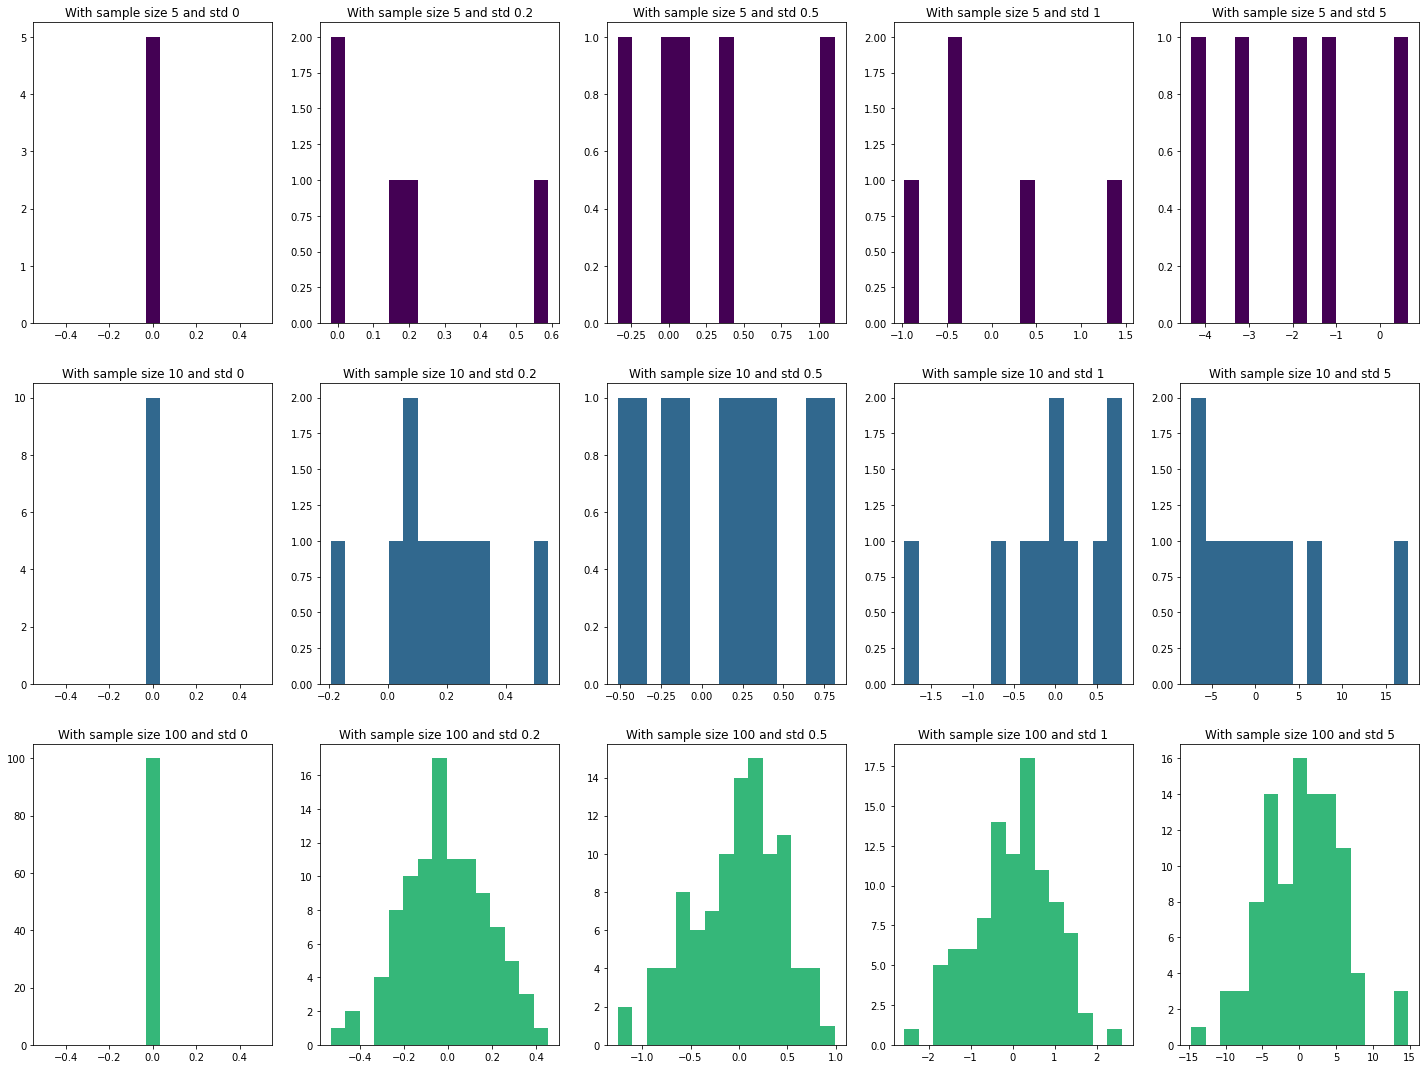

In [20]:
import matplotlib.cm as cm
#trying different sample sizes and sigma values.
sample_size = [5,10,100]
sigmas = [0,0.2,0.5,1,5]

#Creating different colors for the sample sizes.
cmap = cm.get_cmap('viridis')
samplesize_color = []
for s in range(0,len(sample_size)):
    samplesize_color.append(cmap(s/len(sample_size)))


#Get the statistics of the normal distributions into this list.
normal_stats = []
graph_no = 1
color_index = 0
fig = plt.figure(figsize=(14,8))
#We are going to loop and plot a graph for each of these
for size in sample_size:    
    for sigma in sigmas:
        #generate samples from normal dist
        data = np.random.normal(0, sigma, size) 
        sp = fig.add_subplot(len(sample_size),len(sigmas), graph_no)
        sp.set_title("With sample size {} and std {}".format(str(size),str(sigma)))
        sp.hist(data,bins=15, color=samplesize_color[color_index])
        #Gather the statistics
        row = [size,sigma,np.mean(data),np.std(data),stats.skew(data),stats.kurtosis(data)]
        normal_stats.append(row)           
        graph_no += 1
    color_index +=1
plt.subplots_adjust(right=1.5, top=1.9) 
plt.show()                


In [15]:
stats_df = pd.DataFrame(normal_stats,columns=["sample_size","sigma","mean","std","skewness","kurtosis"])
stats_df

,sample_size,sigma,mean,std,skewness,kurtosis
0,5,0.0,0.000000,0.000000,0.000000,-3.000000
1,5,0.2,0.001563,0.067293,0.520879,-0.930776
2,5,0.5,-0.383271,0.145176,1.378306,0.090598
3,5,1.0,0.643959,0.768798,0.267019,-0.586898
4,5,5.0,0.662309,4.825962,-0.090196,-1.517535
5,10,0.0,0.000000,0.000000,0.000000,-3.000000
6,10,0.2,-0.055531,0.271719,-1.308739,1.422617
7,10,0.5,-0.168276,0.449140,0.551864,-0.796461
8,10,1.0,0.402132,1.044704,0.001603,-0.711671
9,10,5.0,-0.084270,3.765856,0.443486,-0.936796


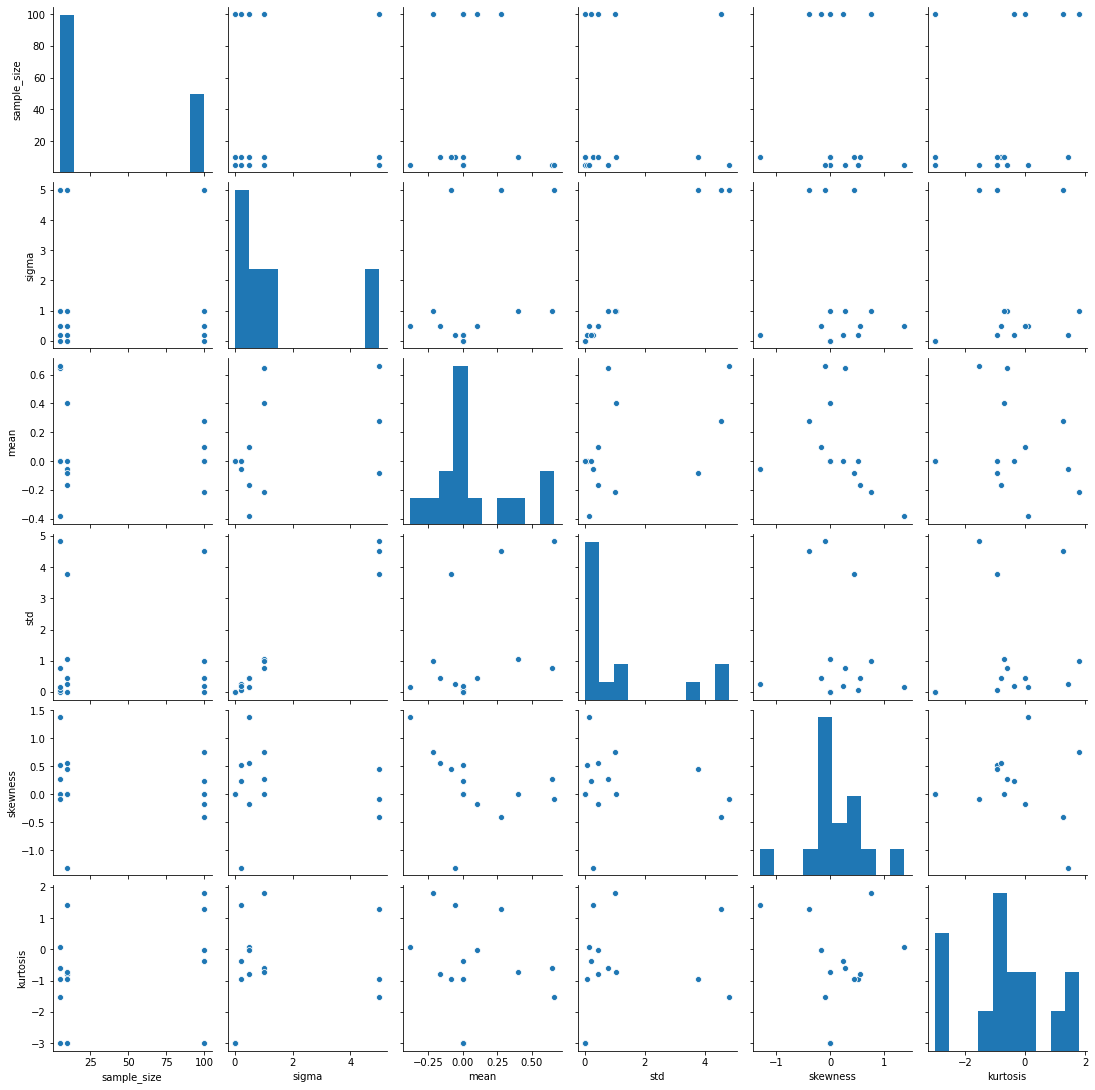

In [16]:
#plotting all variables against each other.
sns.pairplot(stats_df)
plt.show()

<p>We will now be trying it for a Poisson distribution, much like a normal distribution, the poisson distribution has different variables- $\lambda$- the total number of events ($k$) divided by the number of units ($n$) in the data and $k$- total number of events.</p>

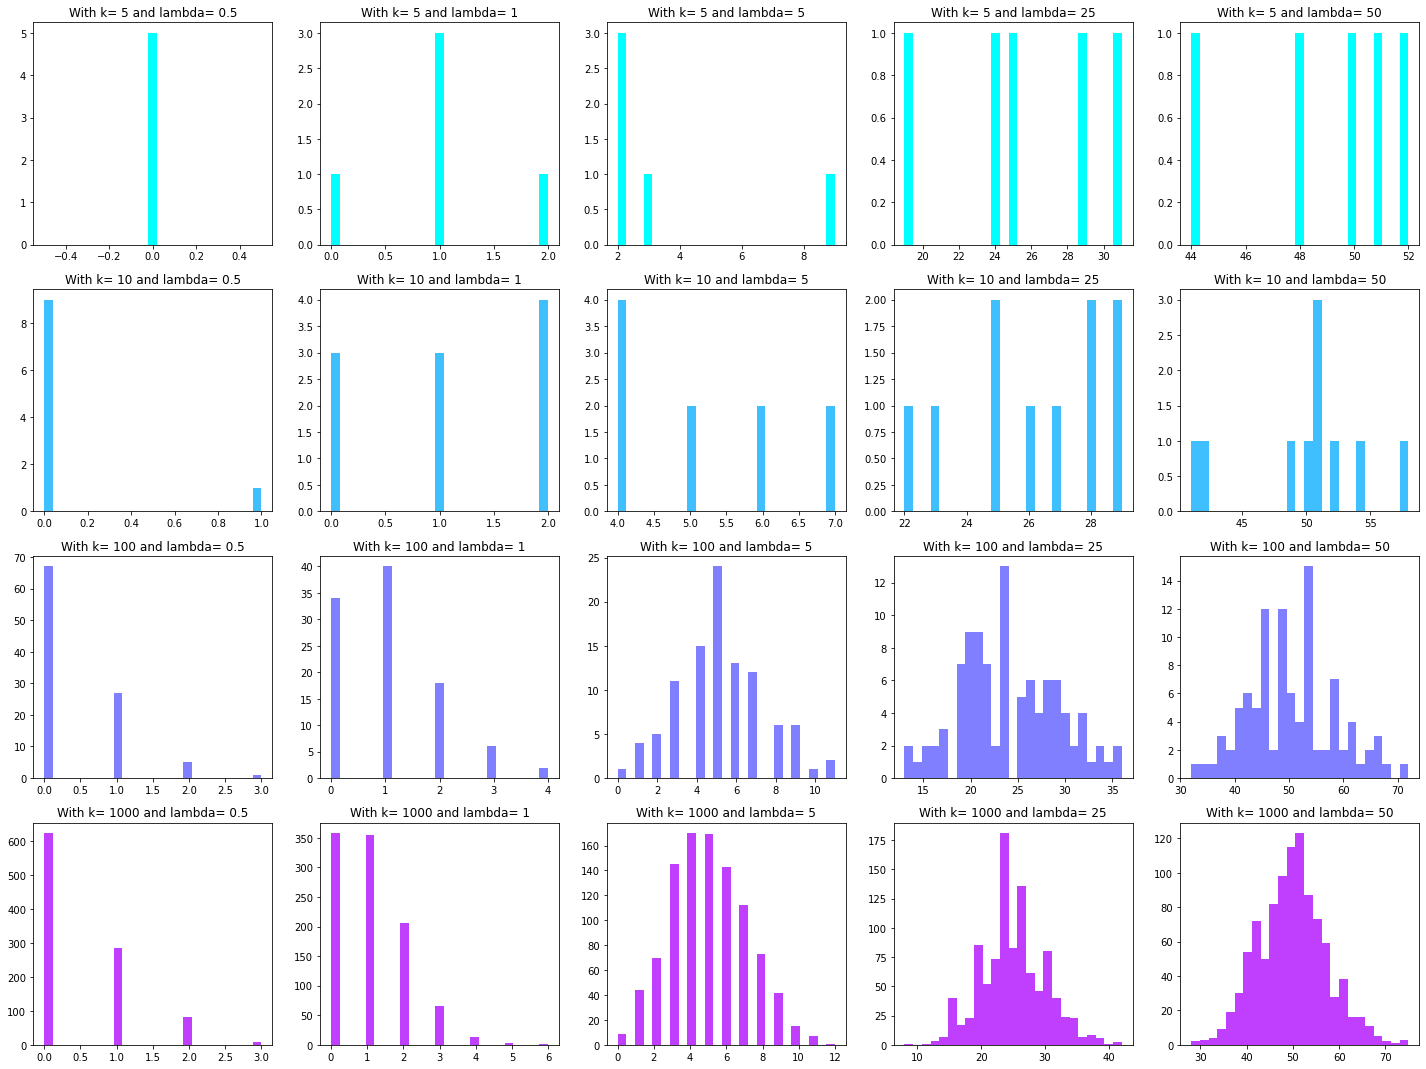

In [17]:
#trying different number of events and different and different events/ number of units
ks = [5,10,100,1000]
lambdas = [0.5,1,5,25,50] 

#Creating different colors for the sample sizes.
cmap = cm.get_cmap('cool')
k_color = []
for s in range(0,len(ks)):
    k_color.append(cmap(s/len(ks)))


#Get the statistics of the normal distributions into this list.
poisson_stats = []
graph_no = 1
color_index = 0
fig = plt.figure(figsize=(14,8))
#We are going to loop and plot a graph for each of these
for k in ks:
    for lamda in lambdas: #don't laugh- lambda is a reserved word
        #generate samples from poisson dist
        data = np.random.poisson(lamda, k) 
        sp = fig.add_subplot(len(ks),len(lambdas), graph_no)
        sp.set_title("With k= {} and lambda= {}".format(str(k),str(lamda)))
        sp.hist(data,bins=25, color = k_color[color_index])
        #Gather the statistics
        row = [k,lamda,np.mean(data),np.std(data),stats.skew(data),stats.kurtosis(data)]
        poisson_stats.append(row)           
        graph_no += 1
    color_index +=1
plt.subplots_adjust(right=1.5, top=1.9)   
plt.show()                


In [18]:
poisson_df = pd.DataFrame(poisson_stats,columns=["k","lamda","mean","std","skewness","kurtosis"])
poisson_df

,k,lamda,mean,std,skewness,kurtosis
0,5,0.5,0.000,0.000000,0.000000,-3.000000
1,5,1.0,1.000,0.632456,0.000000,-0.500000
2,5,5.0,3.600,2.727636,1.428627,0.143774
3,5,25.0,25.600,4.176123,-0.260986,-1.100896
4,5,50.0,49.000,2.828427,-0.795495,-0.737500
5,10,0.5,0.100,0.300000,2.666667,5.111111
6,10,1.0,1.100,0.830662,-0.188430,-1.526150
7,10,5.0,5.200,1.166190,0.363173,-1.371972
8,10,25.0,26.200,2.315167,-0.437092,-1.035086
9,10,50.0,49.900,4.825971,-0.520584,-0.275015


<p>Plotting boxplots for the different columns. </p>

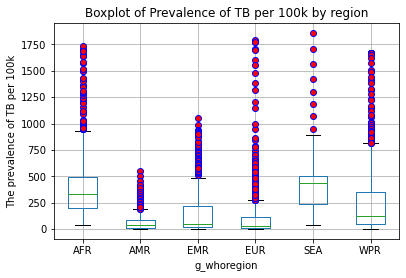

In [19]:
#Creating boxplots of their price and mileage 
#First price
flierprops = dict(marker='o',markerfacecolor='r', markeredgecolor='b')
TB_knn.boxplot("e_prev_100k",by="g_whoregion", flierprops=flierprops)
plt.ylabel("The prevalence of TB per 100k")
plt.title("Boxplot of Prevalence of TB per 100k by region")
plt.suptitle("") #Adjust top title.
plt.show()